In [1]:
import os
import sys
lib_path = os.path.abspath(os.path.join(os.path.abspath(''), 'functions/'))
sys.path.append(lib_path)
# need to append our functions dir to the path! 
import dalecLoad as dl

import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import spectralConv
import seaborn as sns

import datetime

from scipy.signal import savgol_filter


In [ ]:
# using load_DALEC_dir might lead to v large files all being loaded into memory all at once
# therefore, perhaps better to be smarter than this!
logs_81_84 = dl.load_DALEC_dir('data/logs_81_84/', file_names=['LOG_0082.dtf'])

In [ ]:
logs_81_84

In [ ]:
log_81_re = dl.resampleMultiLog(logs_81_84, freq='5min')

In [ ]:
spect_w = dl.load_DALEC_spect_wavelengths('data/logs_81_84/LOG_0081.dtf')
ug = dl.uniform_grid_spectra_multi(log_81_re, spect_w, resample_to_SDs=False)


In [ ]:
sns.lineplot(data=ug, x='Wavelength', y='Rrs_median', hue='Date')

# Process multiple files and save to csv for Dalin's processing

In [ ]:
spect_w = dl.load_DALEC_spect_wavelengths('data/logs_81_84/LOG_0081.dtf')

savWindowLen = 21 # 21 nm is recommeneded by Jiang et al., 2020, ISPRS.
                  # https://doi.org/10.1016/j.isprsjprs.2020.05.003
savPolyOrder = 4
# Dalin doesn't specify in the paper what filter order, but I think he uses R and 4 appears to be the deafult  


outputFileName = 'TEST.csv'

DALEC_files = []
for file in os.listdir('data/logs_81_84/'):
    if file.endswith(".dtf"):
        DALEC_files.append(file)

for i, filen in enumerate(DALEC_files):
    # load log
    log = dl.load_DALEC_dir('data/logs_81_84/', file_names=[filen])
    # resample to 5 min intervals
    log_re = dl.resampleMultiLog(log, freq='5min')
    # regrid and calc Rrs
    df_gridded = dl.uniform_grid_spectra_multi(log_re, spect_w, resample_to_SDs=False)
    # reformat
    df_gridded.drop(labels=['Lu_median', 'Lsky_median', 'Ed_median'], axis=1, inplace=True)
    df1 = df_gridded.unstack().add_prefix('Rrs') # get into wide format
    df1 = df1['RrsRrs_median'] # remove abstract col header Rrs_median
    df1.columns = [col[:-2] for col in df1.columns] # remove '.0' from end of col names
    # apply savgol filter
    dfSmooth = df1.apply(lambda x: savgol_filter(x, savWindowLen, savPolyOrder),
                     axis=1, result_type='broadcast')
    
    Rcode_path = os.path.abspath(os.path.join(os.path.abspath(''), 'R-code/'))

    outputPath = os.path.join(Rcode_path, 'data/' + outputFileName)
    if i == 0:
        dfSmooth.to_csv(outputPath, mode='w')
    else:
        dfSmooth.to_csv(outputPath, mode='a', header=False) # use append mode to add all data to one csv

In [3]:
# more work needed!!!!
# think only the dateOnly thing doesn't work, so fine for my work atm

def reloadDeltaCorr(filepath, keepFlags=0, onlyRrs=True, dropFlag=False, keepDelta=False, dateOnly=False):
    '''
    loads csv file generated by Dalin's R code into pandas df
    keepFlags selects which DeltaCor_flag should be accepted
        eg. keepFlags=[0, 1] will keep good data AND data with Oxygen aborption flag
        flags:
            0: good data
            1: Oxygen aborption at 760nm is too strong, may influence the Rrs shape
            2: out of the training range of the method
            3: extremely turbid, algae bloom, floating materials, high TSM waters
            4: negative results between 400-700 nm after delta correction
    onlyRrs drops all other columns except the output Rrs columns
    '''
    df = pd.read_csv(filepath)
    
    if type(keepFlags) is not list:
        keepFlags = [keepFlags]
    
    df = df[df['DeltaCor_flag'].isin(keepFlags)]
    
    if onlyRrs:
        if keepDelta:
            df.drop(['Unnamed: 0', 'Rrs400', 'DeltaCor_method', 'RHW'], 
                   axis=1, inplace=True)
        else:
            df.drop(['Unnamed: 0', 'Rrs400', 'DeltaCor_method', 'RHW', 'Delta'], 
                   axis=1, inplace=True)
    if dropFlag:
        df.drop(['DeltaCor_flag'], 
               axis=1, inplace=True)
        
    df.rename(columns={'Rrs400.1': 'Rrs400'}, inplace=True)
    #df['id'] = df.index
    df_long = pd.wide_to_long(df, 'Rrs', i='Date', j='Wavelength')
    
    df_long.sort_index(inplace=True)
    

    
    # currently dateOnly doesn't do what I want! need to rename the index! 

    df_long.index = pd.MultiIndex.from_arrays([pd.to_datetime(df_long.index.get_level_values(level=0)),
                                               df_long.index.get_level_values(level=1)])
    
    if dateOnly:
        # resample to daily 
        df_long = df_long.groupby([pd.Grouper(freq='1d', level=0)] + ['Wavelength']).median()
        df_long.index = pd.MultiIndex.from_arrays([pd.to_datetime(df_long.index.get_level_values(level=0)).date,
                                                   df_long.index.get_level_values(level=1)])
        df_long.index.names = ['Date', 'Wavelength']
    
    return df_long

In [4]:
# load delta corrected spectra
dalecDelta = reloadDeltaCorr('R-code/data/TEST_DeltaCor_Jiang.csv',
                            )

In [5]:
dalecDelta.reset_index(inplace=True)
dalecDelta['date'] = dalecDelta.Date.dt.date

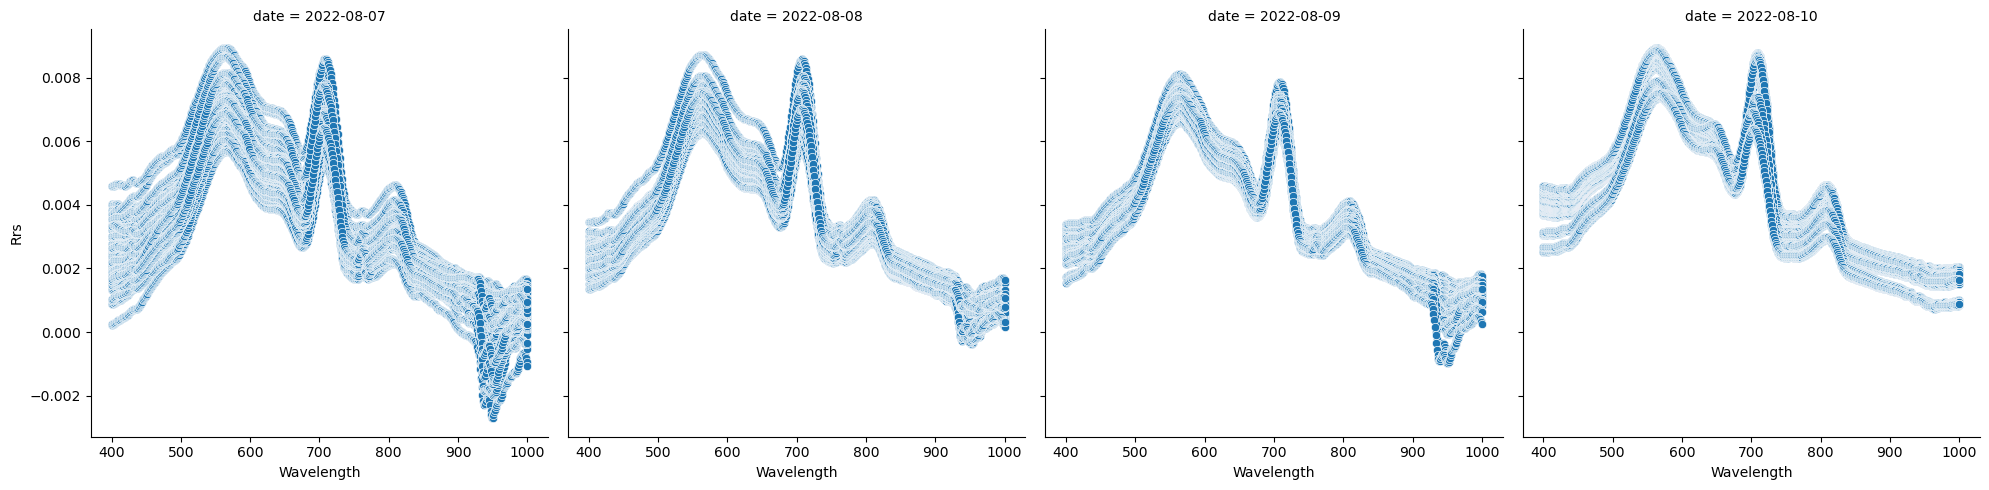

In [6]:
sns.relplot(data=dalecDelta, x='Wavelength', y='Rrs', col='date')

In [24]:
dalecDelta.Date.dt.date

0         2022-08-07
1         2022-08-07
2         2022-08-07
3         2022-08-07
4         2022-08-07
             ...    
115387    2022-08-10
115388    2022-08-10
115389    2022-08-10
115390    2022-08-10
115391    2022-08-10
Name: Date, Length: 115392, dtype: object

# Now try and saving and loading all the data...

In [3]:
spect_w = dl.load_DALEC_spect_wavelengths('data/calibrated_full/2022/LOG_0071.dtf')

savWindowLen = 21 # 21 nm is recommeneded by Jiang et al., 2020, ISPRS.
                  # https://doi.org/10.1016/j.isprsjprs.2020.05.003
savPolyOrder = 4
# Dalin doesn't specify in the paper what filter order, but I think he uses R and 4 appears to be the deafult  


outputFileName = '2022.csv'

DALEC_files = []
for file in os.listdir('data/calibrated_full/2022_good_files/'):
    if file.endswith(".dtf") and file not in ['LOG_0098.dtf',
                                              'LOG_0099.dtf'
                                              'LOG_0100.dtf'
                                              'LOG_0107.dtf']:
        DALEC_files.append(file)

for i, filen in enumerate(DALEC_files):
    # load log
    log = dl.load_DALEC_dir('data/calibrated_full/2022_good_files/', 
                            file_names=[filen])
    print('loaded. Now resampling, regridding etc... \n')
    # resample to 5 min intervals
    log_re = dl.resampleMultiLog(log, freq='5min')
    # regrid and calc Rrs
    df_gridded = dl.uniform_grid_spectra_multi(log_re, spect_w, resample_to_SDs=False)
    # reformat
    df_gridded.drop(labels=['Lu_median', 'Lsky_median', 'Ed_median'], axis=1, inplace=True)
    df1 = df_gridded.unstack().add_prefix('Rrs') # get into wide format
    df1 = df1['RrsRrs_median'] # remove abstract col header Rrs_median
    df1.columns = [col[:-2] for col in df1.columns] # remove '.0' from end of col names
    # apply savgol filter
    dfSmooth = df1.apply(lambda x: savgol_filter(x, savWindowLen, savPolyOrder),
                     axis=1, result_type='broadcast')
    
    Rcode_path = os.path.abspath(os.path.join(os.path.abspath(''), 'R-code/'))

    outputPath = os.path.join(Rcode_path, 'data/' + outputFileName)
    if i == 0:
        dfSmooth.to_csv(outputPath, mode='w')
    else:
        dfSmooth.to_csv(outputPath, mode='a', header=False) # use append mode to add all data to one csv

loading ... data/calibrated_full/2022_good_files/LOG_0076.dtf
loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0100.dtf
loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0088.dtf
loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0080.dtf
loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0097.dtf
loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0084.dtf
loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0075.dtf
loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0087.dtf
loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_files/LOG_0071.dtf
loaded. Now resampling, regridding etc... 

loading ... data/calibrated_full/2022_good_fil

In [4]:
# load delta corrected spectra
dalecDelta = reloadDeltaCorr('R-code/data/2023_DeltaCor_Jiang.csv',
                             keepFlags=[0, 1, 3], keepDelta=True)

In [5]:
dalecDelta.reset_index(inplace=True)
dalecDelta['date'] = dalecDelta.Date.dt.date

In [6]:
dalecDelta['Rrs_uncorr'] = dalecDelta['Rrs'] + dalecDelta['Delta']
dalecDelta

Date  Wavelength     Delta  DeltaCor_flag       Rrs  \
0       2023-07-08 08:00:00         400  0.003716              1 -0.002389   
1       2023-07-08 08:00:00         401  0.003716              1 -0.002394   
2       2023-07-08 08:00:00         402  0.003716              1 -0.002385   
3       2023-07-08 08:00:00         403  0.003716              1 -0.002363   
4       2023-07-08 08:00:00         404  0.003716              1 -0.002331   
...                     ...         ...       ...            ...       ...   
2466499 2023-09-30 12:50:00         996 -0.003614              1  0.003511   
2466500 2023-09-30 12:50:00         997 -0.003614              1  0.003494   
2466501 2023-09-30 12:50:00         998 -0.003614              1  0.003464   
2466502 2023-09-30 12:50:00         999 -0.003614              1  0.003417   
2466503 2023-09-30 12:50:00        1000 -0.003614              1  0.003344   

               date  Rrs_uncorr  
0        2023-07-08    0.001327  
1        2023-07-08    0.001322  
2        2023-07-08    0.001331  
3        2023-07-08    0.001353  
4        2023-07-08    0.001385  
...             ...         ...  
2466499  2023-09-30   -0.000103  
2466500  2023-09-30   -0.000120  
2466501  2023-09-30   -0.000149  
2466502  2023-09-30   -0.000197  
2466503  2023-09-30   -0.000270  

[2466504 rows x 7 columns]

In [7]:
def ruddick2005_corr(deltaDF, alpha=1.91, w1=780, w2=870):
    '''https://odnature.naturalsciences.be/downloads/publications/ruddick_spie_2005.pdf'''
    Rrs_1 = deltaDF[deltaDF.Wavelength==w1]['Rrs_uncorr'].values
    Rrs_2 = deltaDF[deltaDF.Wavelength==w2]['Rrs_uncorr'].values
    error = ((alpha * Rrs_2) - Rrs_1)/(alpha-1)
    deltaDF['ruddick_delta'] = np.repeat(error, len(deltaDF.Wavelength.unique()))
    deltaDF['Rrs_ruddick'] = deltaDF['Rrs_uncorr'] - deltaDF['ruddick_delta']
    
    
ruddick2005_corr(dalecDelta)
    

In [8]:
dalecDelta

Date  Wavelength     Delta  DeltaCor_flag       Rrs  \
0       2023-07-08 08:00:00         400  0.003716              1 -0.002389   
1       2023-07-08 08:00:00         401  0.003716              1 -0.002394   
2       2023-07-08 08:00:00         402  0.003716              1 -0.002385   
3       2023-07-08 08:00:00         403  0.003716              1 -0.002363   
4       2023-07-08 08:00:00         404  0.003716              1 -0.002331   
...                     ...         ...       ...            ...       ...   
2466499 2023-09-30 12:50:00         996 -0.003614              1  0.003511   
2466500 2023-09-30 12:50:00         997 -0.003614              1  0.003494   
2466501 2023-09-30 12:50:00         998 -0.003614              1  0.003464   
2466502 2023-09-30 12:50:00         999 -0.003614              1  0.003417   
2466503 2023-09-30 12:50:00        1000 -0.003614              1  0.003344   

               date  Rrs_uncorr  ruddick_delta  Rrs_ruddick  
0        2023-07-08    0.001327       0.006122    -0.004795  
1        2023-07-08    0.001322       0.006122    -0.004800  
2        2023-07-08    0.001331       0.006122    -0.004791  
3        2023-07-08    0.001353       0.006122    -0.004769  
4        2023-07-08    0.001385       0.006122    -0.004737  
...             ...         ...            ...          ...  
2466499  2023-09-30   -0.000103      -0.000021    -0.000081  
2466500  2023-09-30   -0.000120      -0.000021    -0.000099  
2466501  2023-09-30   -0.000149      -0.000021    -0.000128  
2466502  2023-09-30   -0.000197      -0.000021    -0.000175  
2466503  2023-09-30   -0.000270      -0.000021    -0.000248  

[2466504 rows x 9 columns]

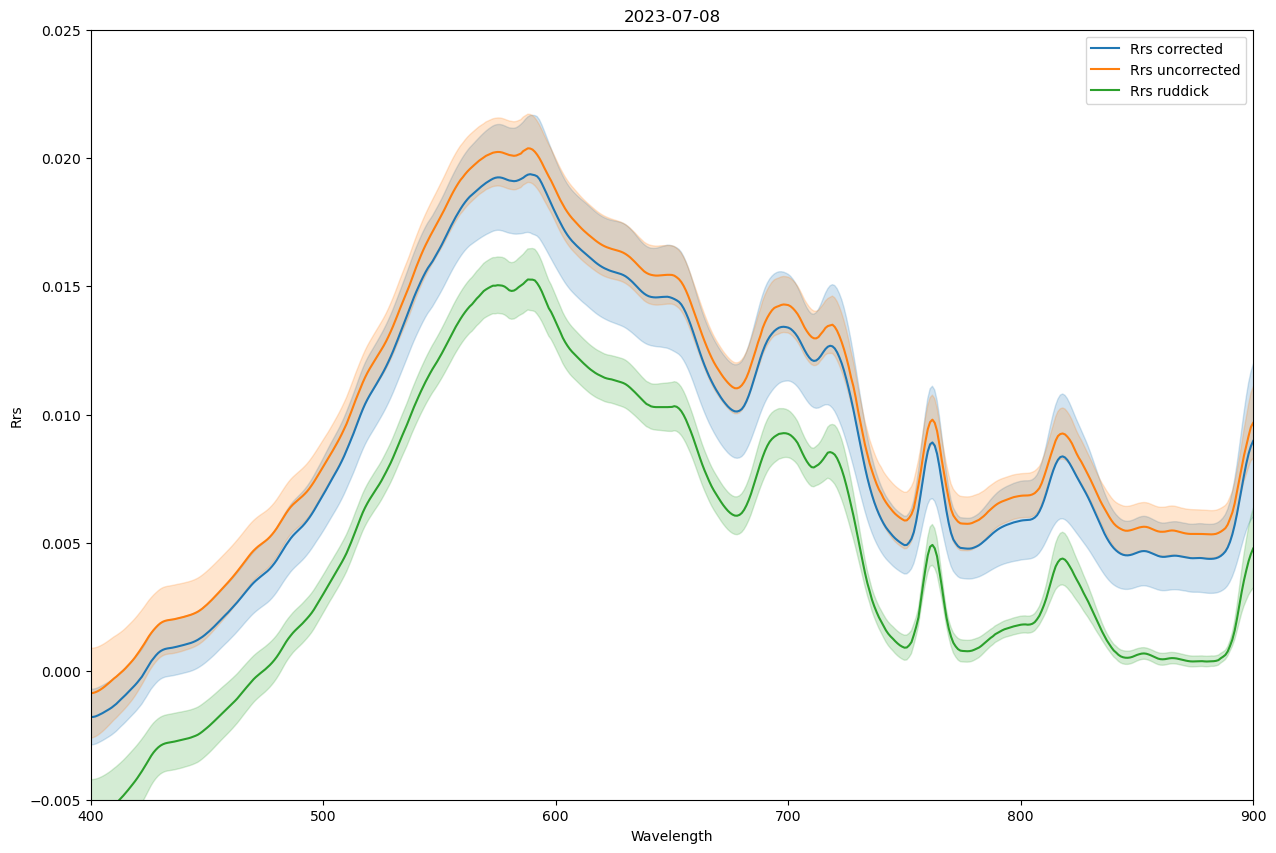

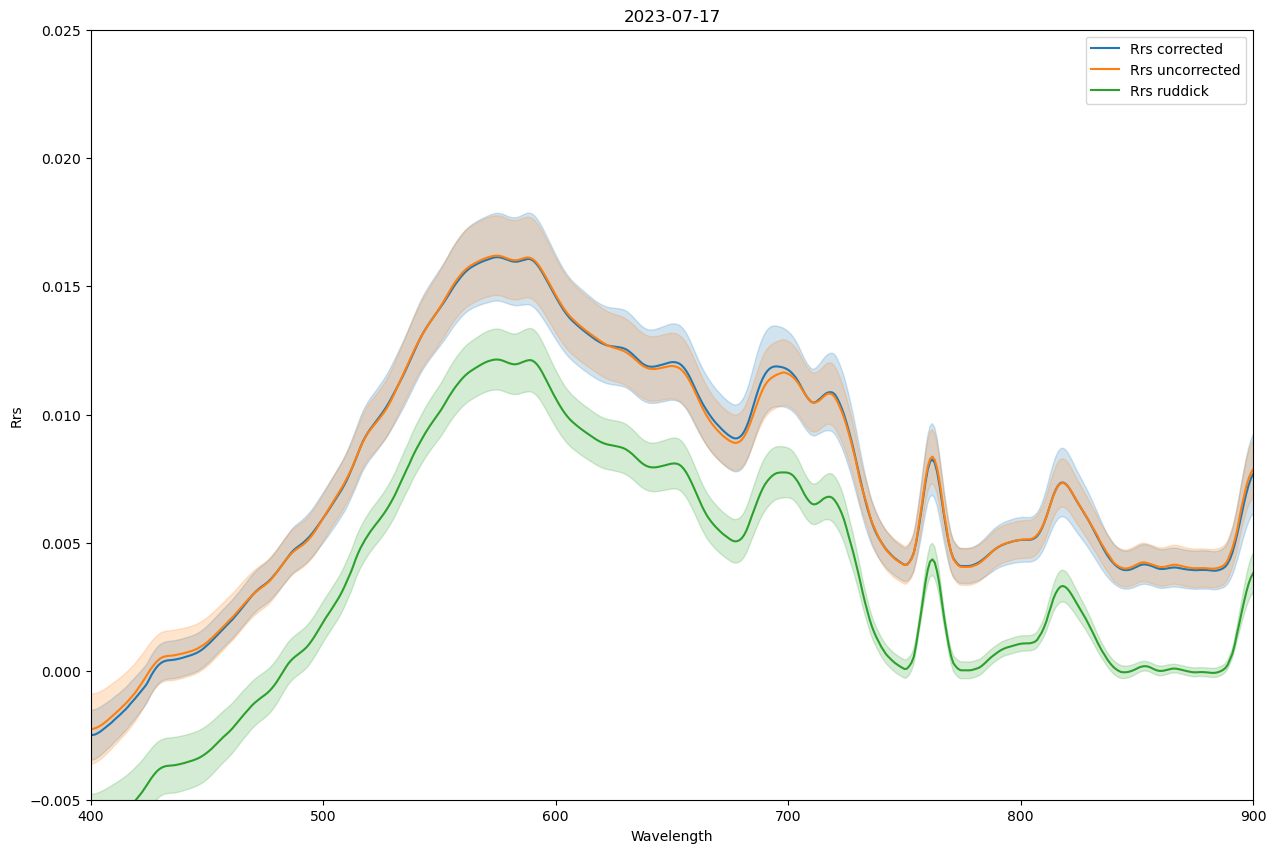

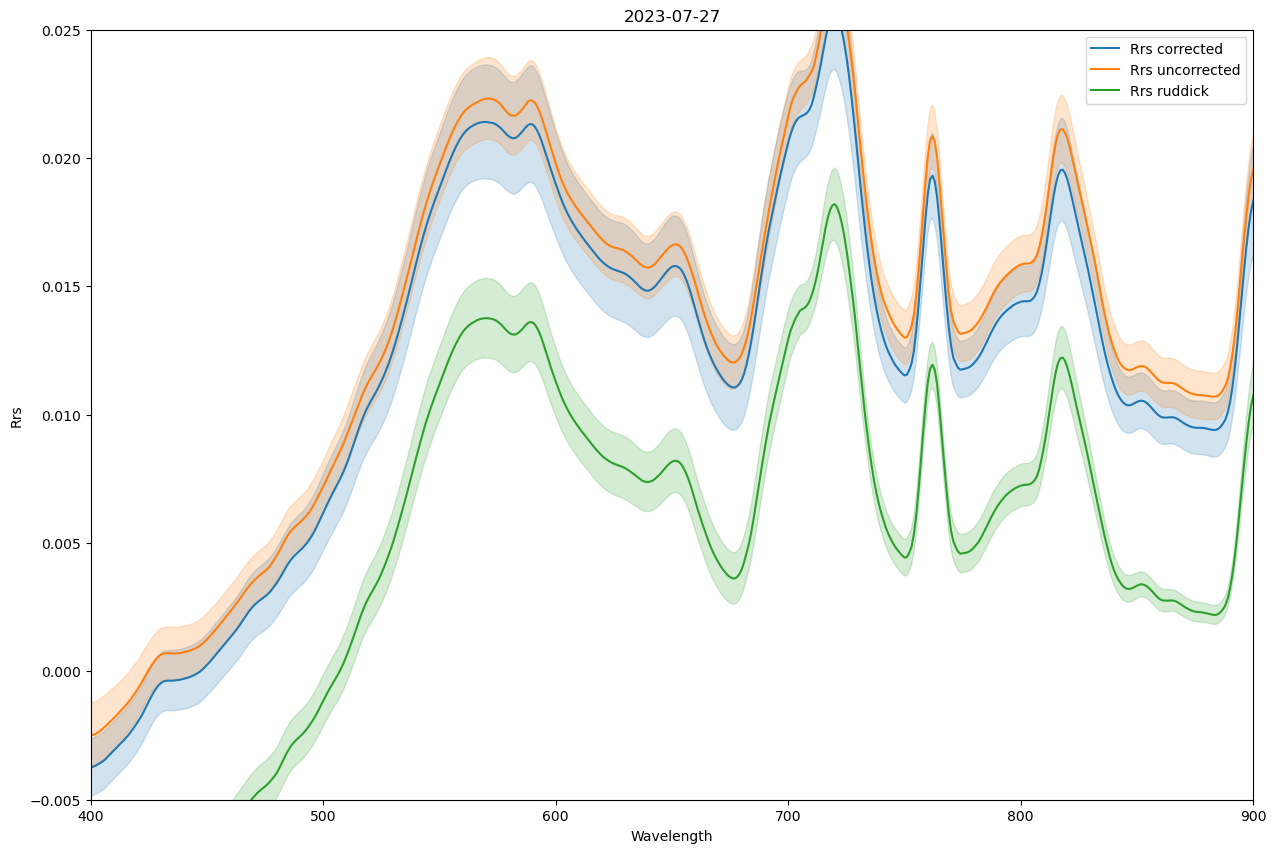

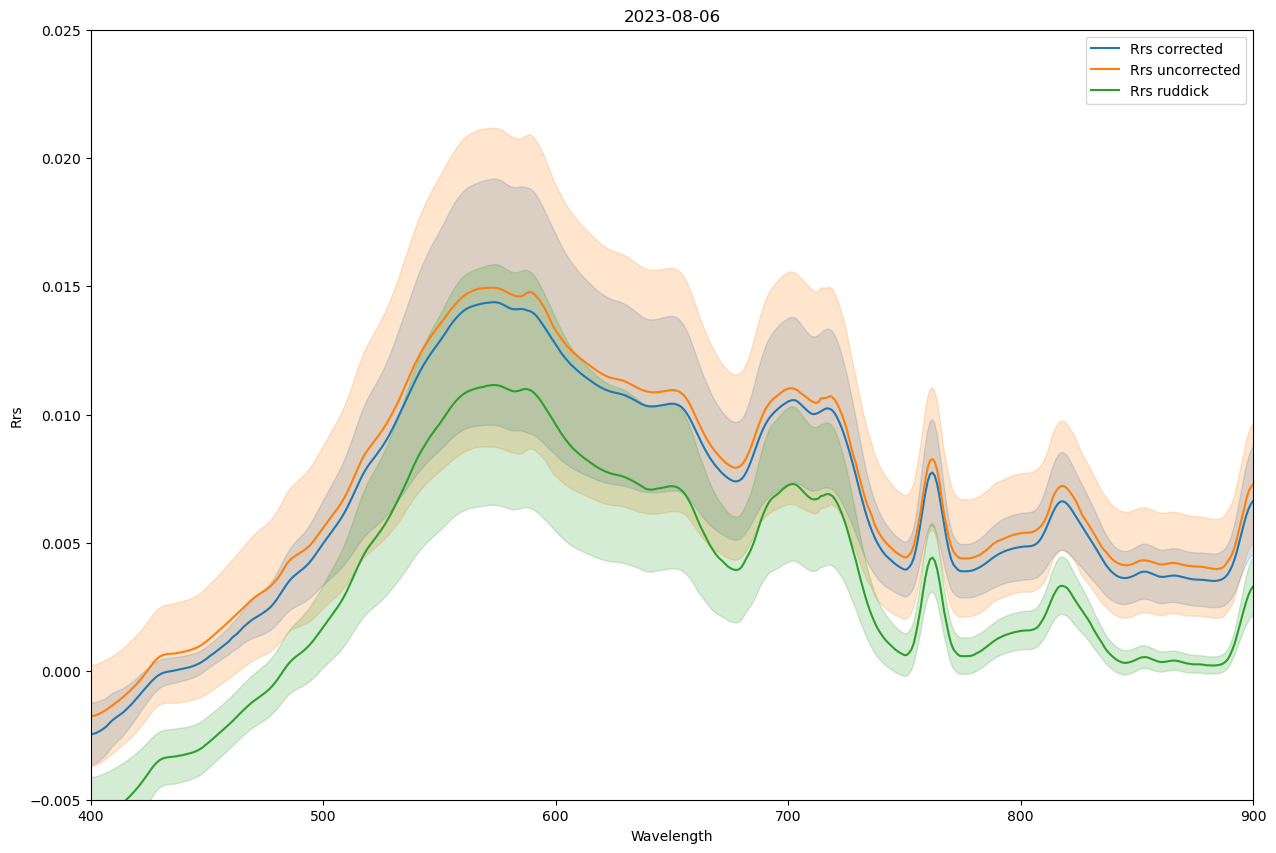

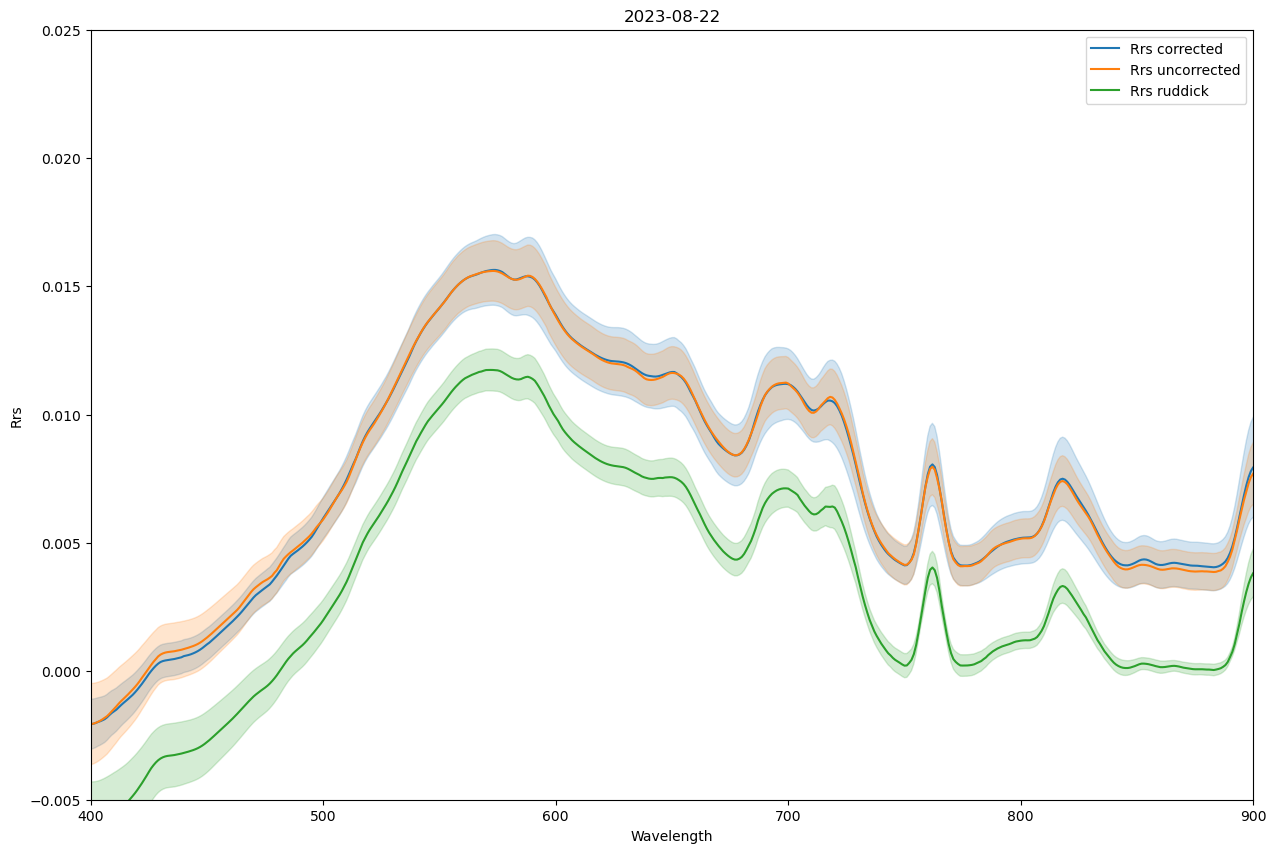

In [9]:
for date in ['2023-07-08', '2023-07-17', '2023-07-27', '2023-08-06', '2023-08-22']:

    fig, ax = plt.subplots(1, 1, figsize=(15,10))
    sns.lineplot(data=dalecDelta[dalecDelta.date == pd.Timestamp(date).date()],
                 x='Wavelength', y='Rrs',
                 errorbar='sd', 
                 estimator='median',
                 #hue='Date', 
                 label='Rrs corrected',
                 legend=True)
    sns.lineplot(data=dalecDelta[dalecDelta.date == pd.Timestamp(date).date()],
                 x='Wavelength', y='Rrs_uncorr',
                 errorbar='sd', 
                 estimator='median',
                 #hue='Date', 
                 label='Rrs uncorrected',
                 legend=True)
    sns.lineplot(data=dalecDelta[dalecDelta.date == pd.Timestamp(date).date()],
                 x='Wavelength', y='Rrs_ruddick',
                 errorbar='sd', 
                 estimator='median',
                 #hue='Date', 
                 label='Rrs ruddick',
                 legend=True)
    plt.xlim(400, 900)
    plt.ylim(-0.005, 0.025)
    plt.title(date)
    plt.legend()
    plt.show()

KeyboardInterrupt: 

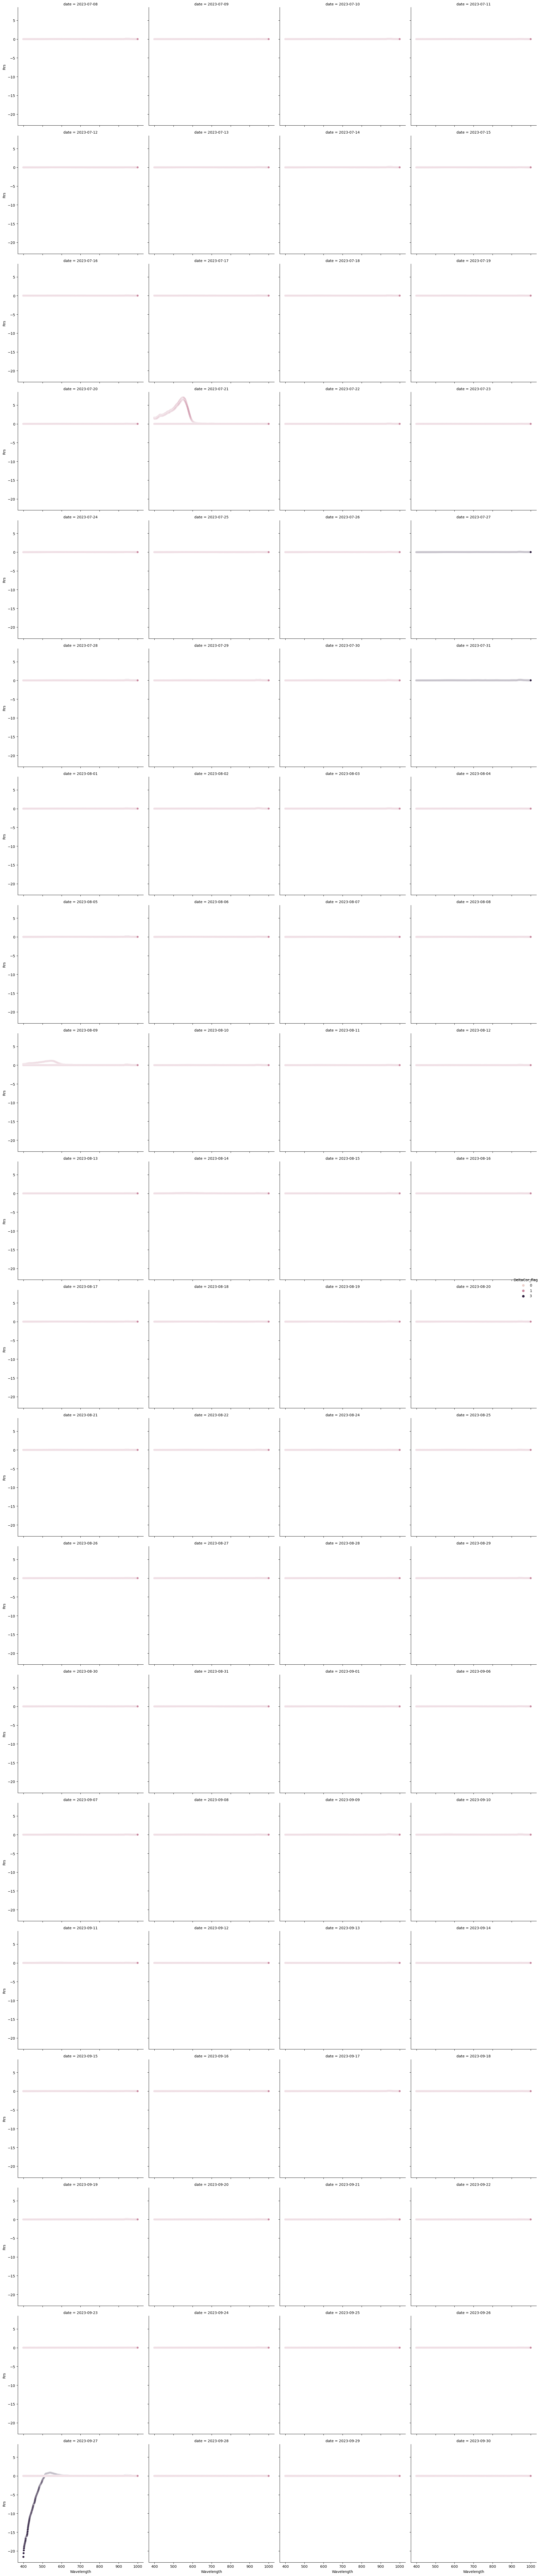

In [10]:
g = sns.relplot(data=dalecDelta, x='Wavelength', y='Rrs', col='date', col_wrap=4, hue='DeltaCor_flag')
g.set(ylim=(0, 0.04))

In [12]:
# load delta corrected spectra
dalecDelta_22 = reloadDeltaCorr('R-code/data/2022_DeltaCor_Jiang.csv',
                             keepFlags=[0, 1, 2, 3, 4], )

In [13]:
dalecDelta_22.reset_index(inplace=True)
dalecDelta_22['date'] = dalecDelta_22.Date.dt.date

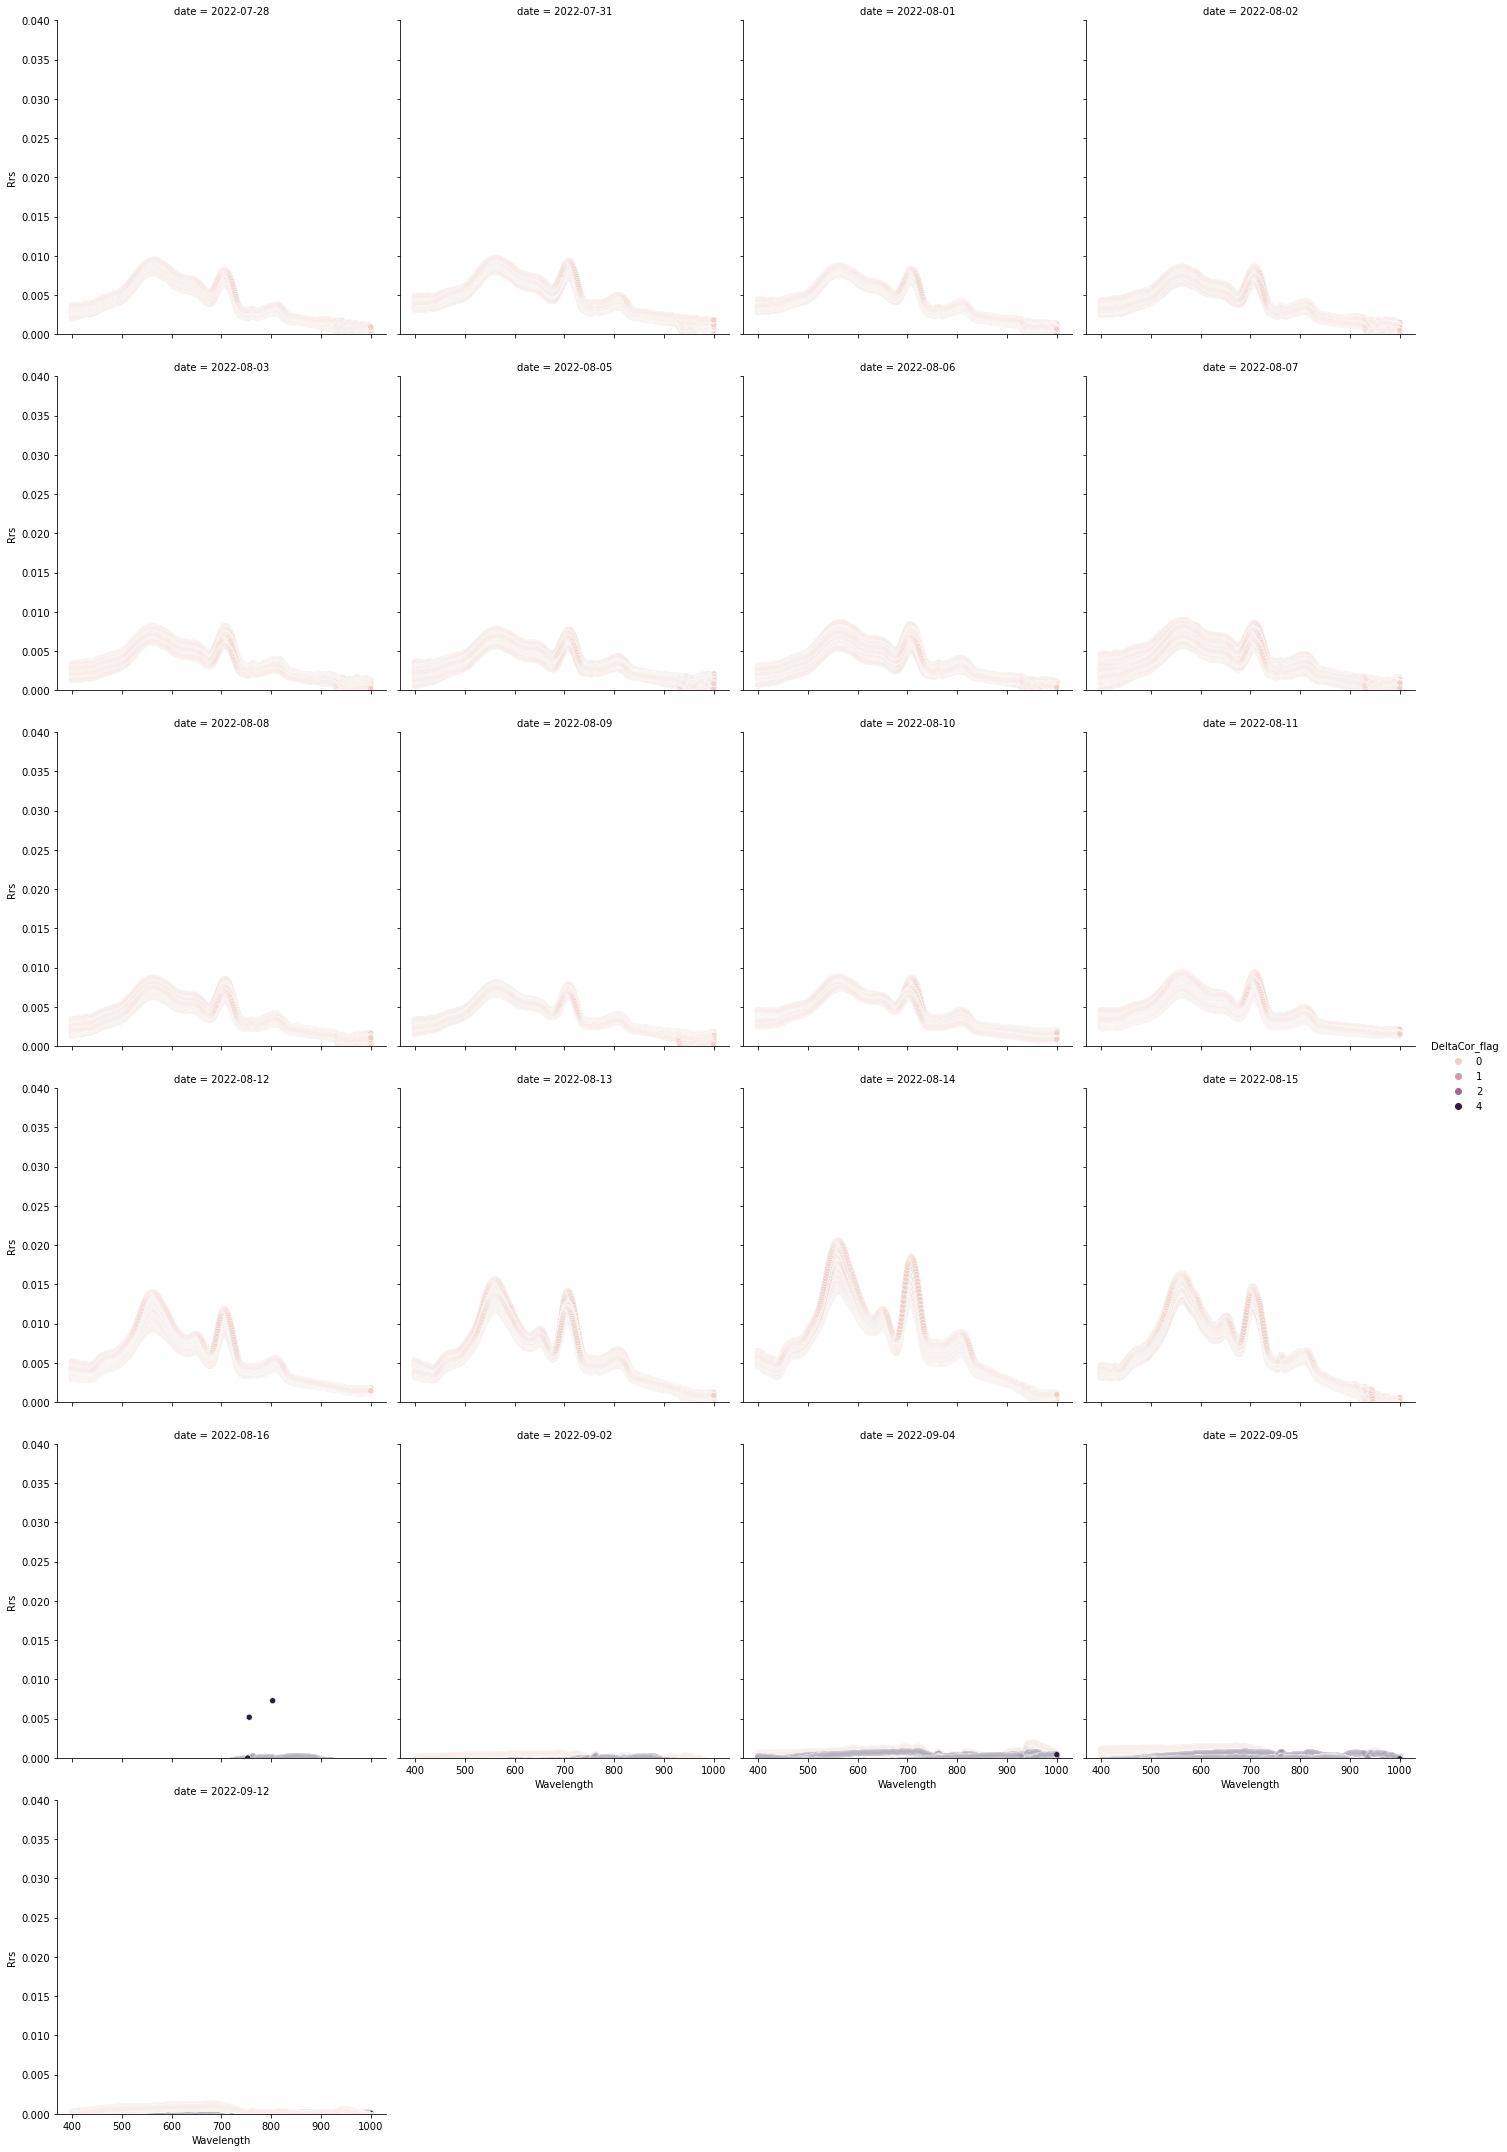

In [12]:
g = sns.relplot(data=dalecDelta_22, x='Wavelength', y='Rrs', col='date', col_wrap=4, hue='DeltaCor_flag')
g.set(ylim=(0, 0.04))

# Cleaning data

- 2022: just remove 16th Aug onwards
- 2023: 
    - remove flags 2, 4 (out of training range and -ve vals)
    - remove any spectra where Rrs at 580 is > 0.04 (these are rare and probably spurious/uneccesary to analyse.


In [14]:
dfClean = dalecDelta_22[dalecDelta_22.date <= datetime.date.fromisoformat('2022-08-15')]
dfClean.DeltaCor_flag.unique()

array([0, 1])

In [15]:
dalecDelta_22.date > datetime.date.fromisoformat('2022-08-15')

0         False
1         False
2         False
3         False
4         False
          ...  
530678     True
530679     True
530680     True
530681     True
530682     True
Name: date, Length: 530683, dtype: bool

In [16]:
datetime.date.fromisoformat('2022-08-15').month

8

In [45]:
bad_spectra_times = dalecDelta[(dalecDelta.Wavelength == 580) & (dalecDelta.Rrs > 0.04)].Date
dfClean = pd.concat([dfClean, dalecDelta[~dalecDelta.Date.isin(bad_spectra_times)]])

In [46]:
dfClean

Date  Wavelength  DeltaCor_flag       Rrs        date  \
0       2022-07-28 10:00:00         400              0  0.002678  2022-07-28   
1       2022-07-28 10:00:00         401              0  0.002684  2022-07-28   
2       2022-07-28 10:00:00         402              0  0.002695  2022-07-28   
3       2022-07-28 10:00:00         403              0  0.002708  2022-07-28   
4       2022-07-28 10:00:00         404              0  0.002721  2022-07-28   
...                     ...         ...            ...       ...         ...   
2466499 2023-09-30 12:50:00         996              1  0.003511  2023-09-30   
2466500 2023-09-30 12:50:00         997              1  0.003494  2023-09-30   
2466501 2023-09-30 12:50:00         998              1  0.003464  2023-09-30   
2466502 2023-09-30 12:50:00         999              1  0.003417  2023-09-30   
2466503 2023-09-30 12:50:00        1000              1  0.003344  2023-09-30   

            Delta  Rrs_uncorr  ruddick_delta  Rrs_ruddick  
0             NaN         NaN            NaN          NaN  
1             NaN         NaN            NaN          NaN  
2             NaN         NaN            NaN          NaN  
3             NaN         NaN            NaN          NaN  
4             NaN         NaN            NaN          NaN  
...           ...         ...            ...          ...  
2466499 -0.003614   -0.000103      -0.000021    -0.000081  
2466500 -0.003614   -0.000120      -0.000021    -0.000099  
2466501 -0.003614   -0.000149      -0.000021    -0.000128  
2466502 -0.003614   -0.000197      -0.000021    -0.000175  
2466503 -0.003614   -0.000270      -0.000021    -0.000248  

[2848139 rows x 9 columns]

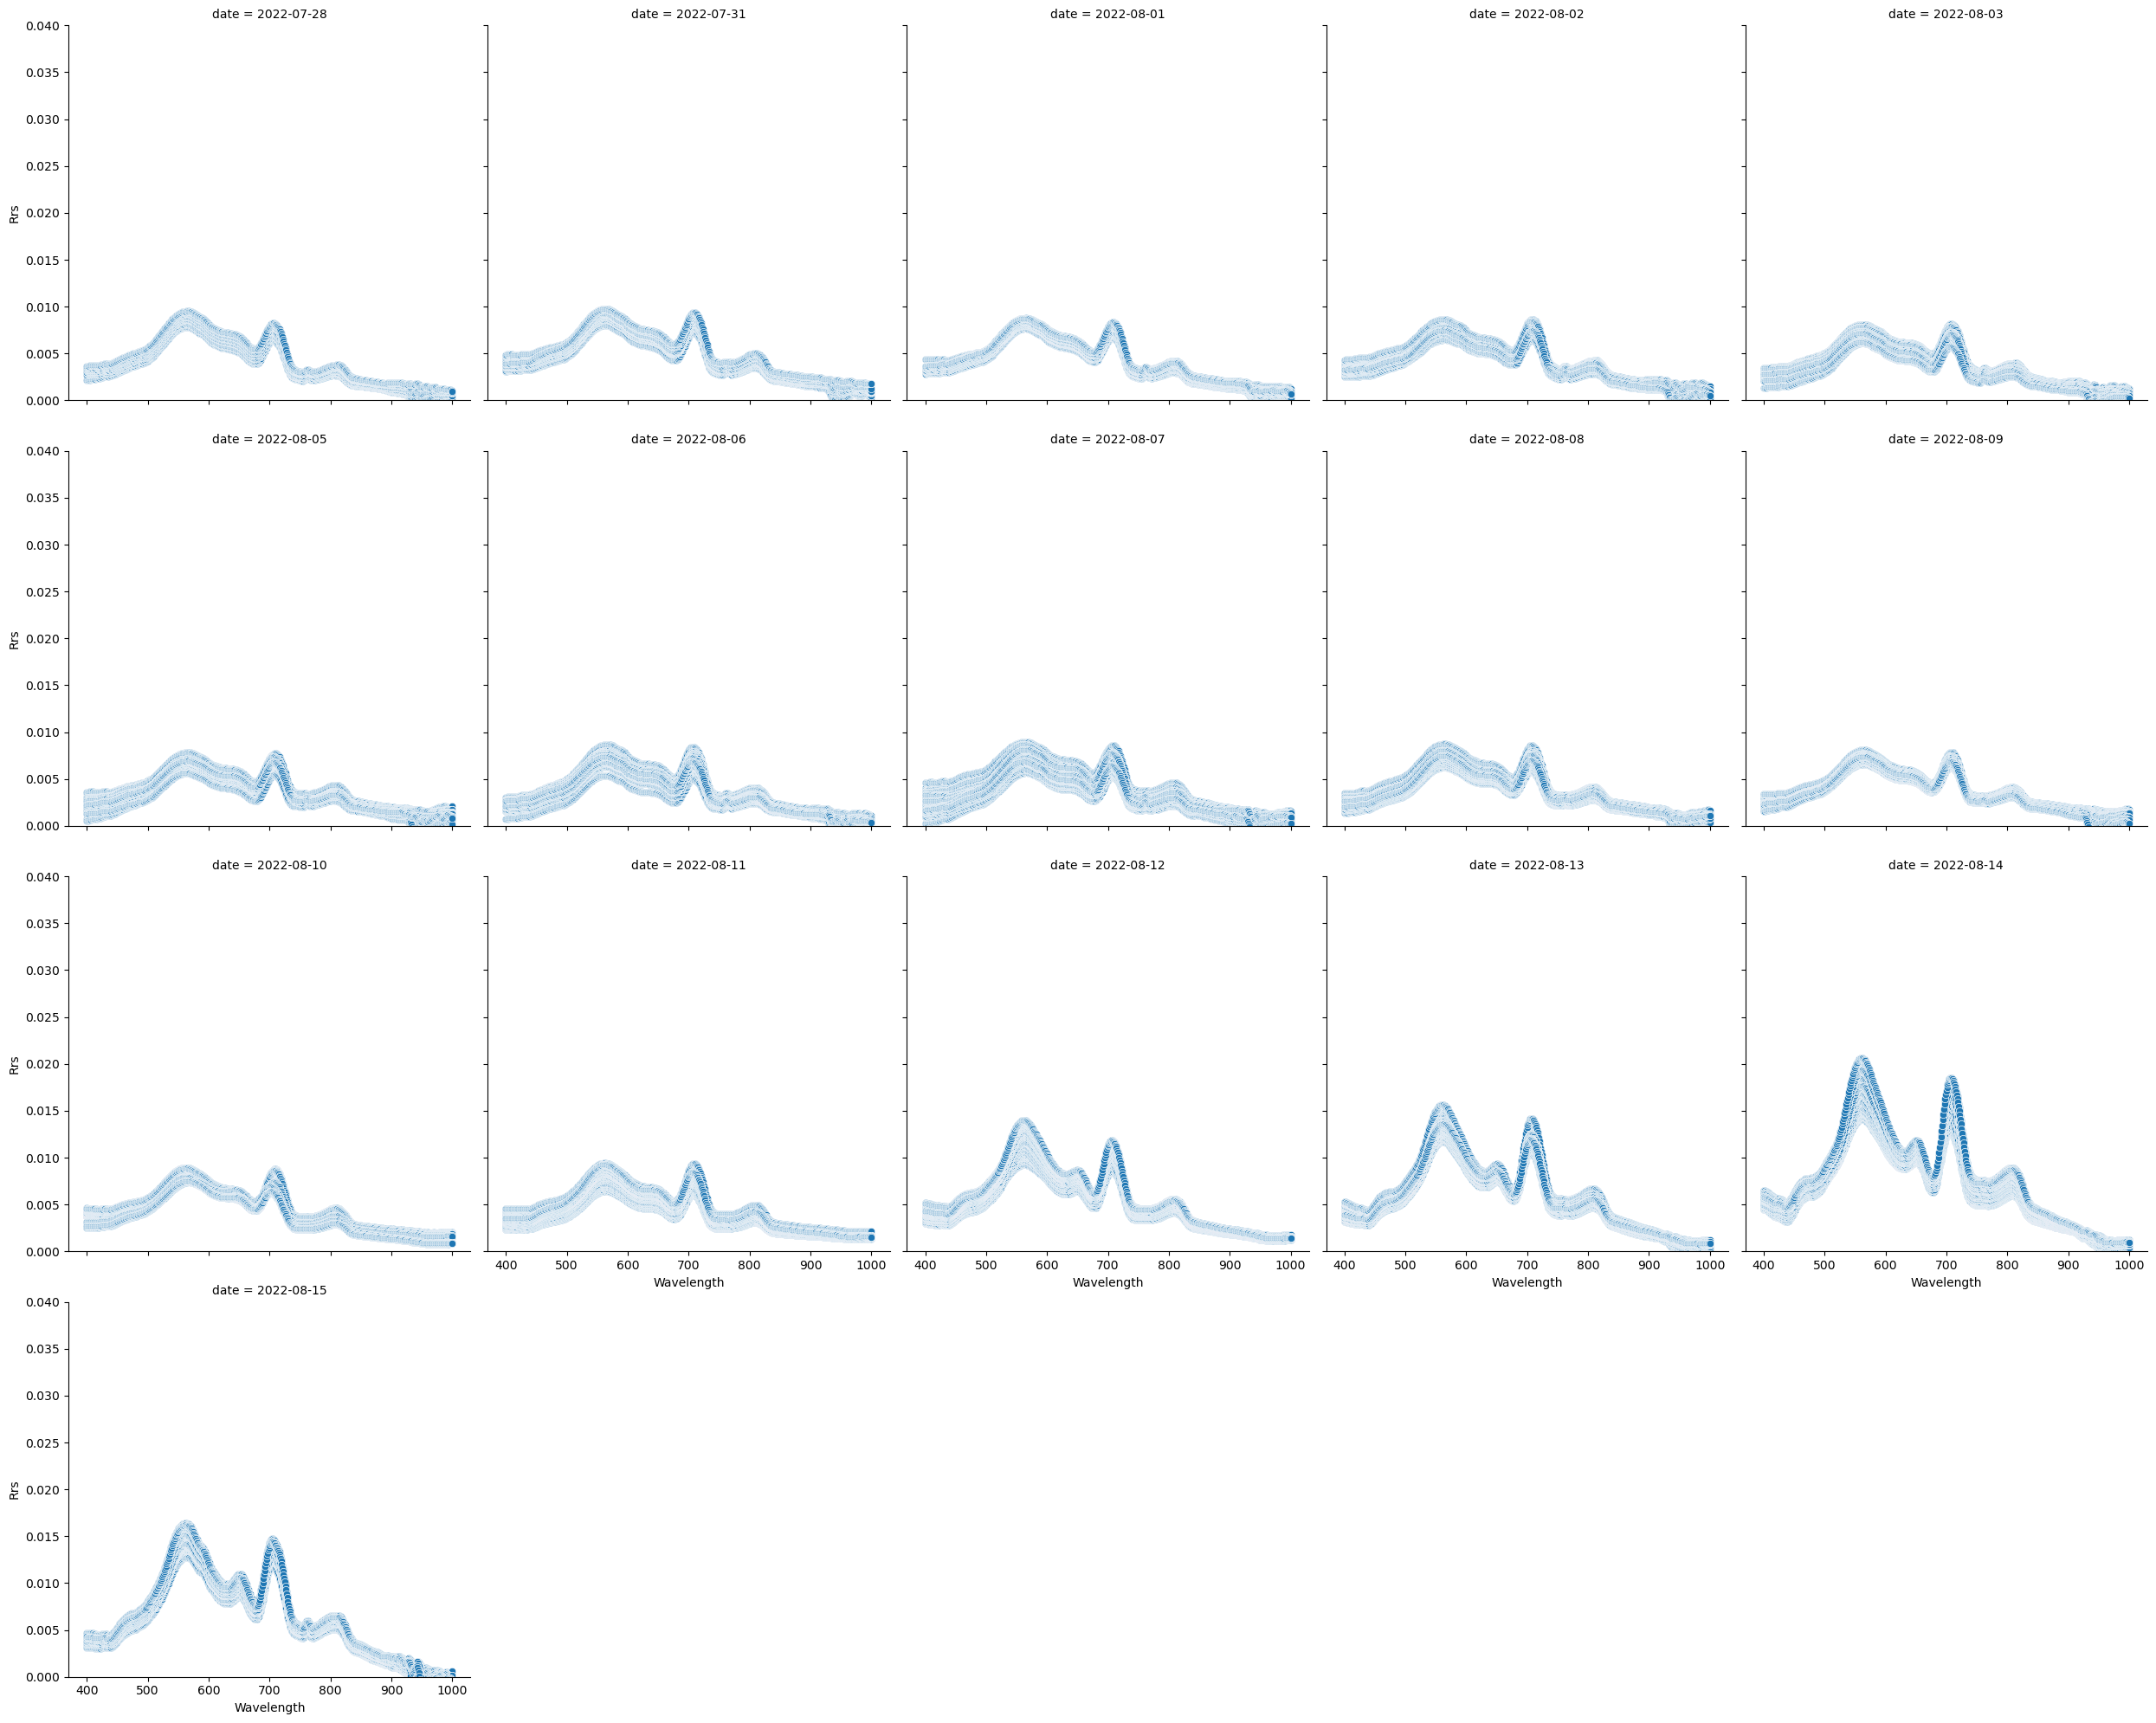

In [18]:
g = sns.relplot(data=dfClean, x='Wavelength', y='Rrs', col='date', col_wrap=5)
g.set(ylim=(0, 0.04))

In [47]:
# resample to doves wavelengths
def resample_to_doves(df):
    '''
    resample a single spectrum
    where df has 1 spectrum contained in it in a column named Rrs
    spectra should be in 1nm intervals from 400-1000 nm
    '''
    RSR_doves_file='non-DALEC-data/RSR-Superdove.csv'
    RSR_doves = pd.read_csv(RSR_doves_file)
    doves_wavelengths = [444., 492., 533., 566., 612., 666., 707., 866.]
    x = RSR_doves['Wavelength (nm)'].values
    
    SD_out = spectralConv.SD_band_calc(RSR_doves, df.Rrs.values, x)
    return pd.DataFrame(data={'Rrs':SD_out, 'wavelength':doves_wavelengths})

# R = dfClean[dfClean.Date == dfClean.Date.values[-100000]].Rrs.values

# SD_out = spectralConv.SD_band_calc(RSR_doves, R, x)

# plt.scatter(doves_wavelengths, SD_out)
# plt.plot(x, R)
# plt.ylim(0, 0.04)
# plt.show()

In [48]:
def resample_to_S2(df):
    '''
    resample a single spectrum
    where df has 1 spectrum contained in it in a column named Rrs
    spectra should be in 1nm intervals from 400-1000 nm
    '''
    RSR_S2_file='non-DALEC-data/RSR-S2A.csv'
    RSR_S2 = pd.read_csv(RSR_S2_file)
    S2_wavelengths = [443., 490., 560., 665., 705., 740., 783.,
                      842., 865., 945., 1375., 1610., 2190.,]
    x = RSR_S2['SR_WL'].values
    
    S2_out = spectralConv.SD_band_calc(RSR_S2, df.Rrs.values, x)
    return pd.DataFrame(data={'Rrs':S2_out, 'wavelength':S2_wavelengths})

In [49]:
pd.DataFrame(data={'sdRrs':SD_out})

NameError: name 'SD_out' is not defined

In [50]:
dfCleanSD = dfClean.groupby('Date').apply(resample_to_doves).reset_index()

In [51]:
dfCleanS2 = dfClean.groupby('Date').apply(resample_to_S2).reset_index()

In [52]:
dfCleanS2.drop('level_1', axis=1, inplace=True)

In [53]:
dfCleanSD.drop('level_1', axis=1, inplace=True)

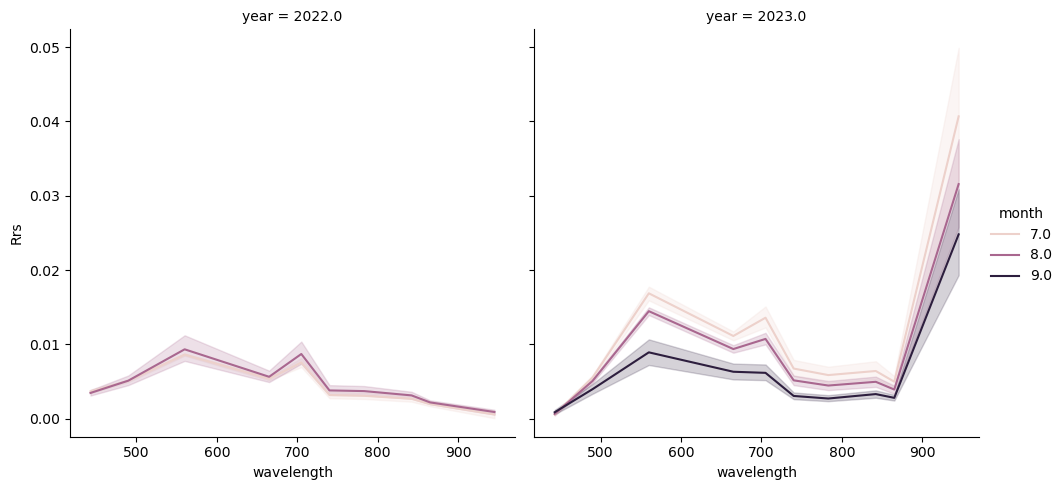

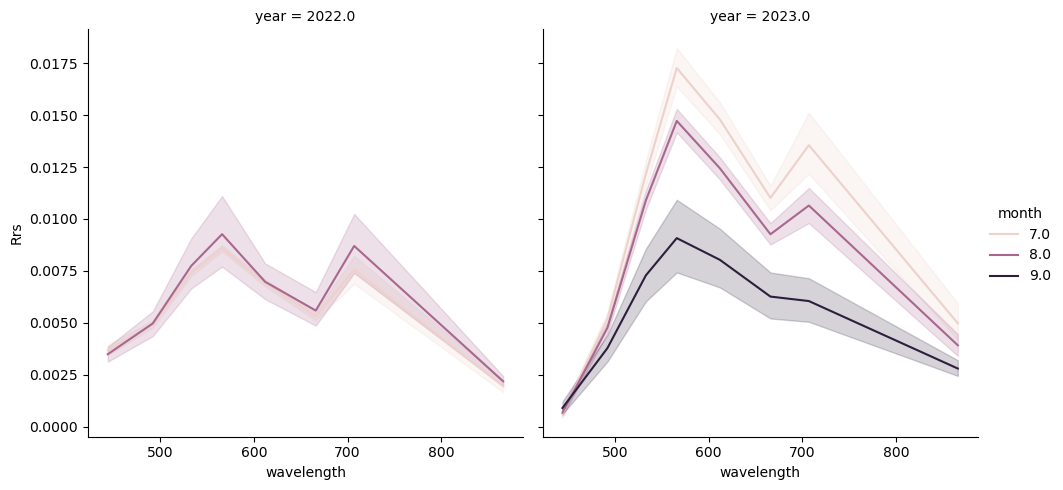

In [54]:
dfCleanSD['date'] = dfCleanSD.Date.dt.date
dfCleanSD['month'] = dfCleanSD.Date.dt.month
dfCleanSD['year'] = dfCleanSD.Date.dt.year
dfCleanS2['date'] = dfCleanS2.Date.dt.date
dfCleanS2['month'] = dfCleanS2.Date.dt.month
dfCleanS2['year'] = dfCleanS2.Date.dt.year


SD_daily = dfCleanSD.groupby(['date', 'wavelength']).median().reset_index()
S2_daily = dfCleanS2.groupby(['date', 'wavelength']).median().reset_index()

sns.relplot(data=S2_daily, x='wavelength', y='Rrs', hue='month', col='year', kind='line')
sns.relplot(data=SD_daily, x='wavelength', y='Rrs', hue='month', col='year', kind='line')

In [55]:
dfCleanSD.Date.dt.date

0        2022-07-28
1        2022-07-28
2        2022-07-28
3        2022-07-28
4        2022-07-28
            ...    
37907    2023-09-30
37908    2023-09-30
37909    2023-09-30
37910    2023-09-30
37911    2023-09-30
Name: Date, Length: 37912, dtype: object

In [56]:
dfClean[dfClean.Date == dfClean.Date.values[0]].Rrs

0      0.002678
1      0.002684
2      0.002695
3      0.002708
4      0.002721
         ...   
596    0.000014
597   -0.000030
598   -0.000089
599   -0.000167
600   -0.000266
Name: Rrs, Length: 601, dtype: float64

In [57]:
dfClean.Date.values[0]

numpy.datetime64('2022-07-28T10:00:00.000000000')

In [58]:
dfClean

Date  Wavelength  DeltaCor_flag       Rrs        date  \
0       2022-07-28 10:00:00         400              0  0.002678  2022-07-28   
1       2022-07-28 10:00:00         401              0  0.002684  2022-07-28   
2       2022-07-28 10:00:00         402              0  0.002695  2022-07-28   
3       2022-07-28 10:00:00         403              0  0.002708  2022-07-28   
4       2022-07-28 10:00:00         404              0  0.002721  2022-07-28   
...                     ...         ...            ...       ...         ...   
2466499 2023-09-30 12:50:00         996              1  0.003511  2023-09-30   
2466500 2023-09-30 12:50:00         997              1  0.003494  2023-09-30   
2466501 2023-09-30 12:50:00         998              1  0.003464  2023-09-30   
2466502 2023-09-30 12:50:00         999              1  0.003417  2023-09-30   
2466503 2023-09-30 12:50:00        1000              1  0.003344  2023-09-30   

            Delta  Rrs_uncorr  ruddick_delta  Rrs_ruddick  
0             NaN         NaN            NaN          NaN  
1             NaN         NaN            NaN          NaN  
2             NaN         NaN            NaN          NaN  
3             NaN         NaN            NaN          NaN  
4             NaN         NaN            NaN          NaN  
...           ...         ...            ...          ...  
2466499 -0.003614   -0.000103      -0.000021    -0.000081  
2466500 -0.003614   -0.000120      -0.000021    -0.000099  
2466501 -0.003614   -0.000149      -0.000021    -0.000128  
2466502 -0.003614   -0.000197      -0.000021    -0.000175  
2466503 -0.003614   -0.000270      -0.000021    -0.000248  

[2848139 rows x 9 columns]

In [83]:
dfClean

Date  Wavelength  DeltaCor_flag       Rrs        date
0       2022-07-28 10:00:00         400              0  0.002678  2022-07-28
1       2022-07-28 10:00:00         401              0  0.002684  2022-07-28
2       2022-07-28 10:00:00         402              0  0.002695  2022-07-28
3       2022-07-28 10:00:00         403              0  0.002708  2022-07-28
4       2022-07-28 10:00:00         404              0  0.002721  2022-07-28
...                     ...         ...            ...       ...         ...
2466499 2023-09-30 12:50:00         996              1  0.003511  2023-09-30
2466500 2023-09-30 12:50:00         997              1  0.003494  2023-09-30
2466501 2023-09-30 12:50:00         998              1  0.003464  2023-09-30
2466502 2023-09-30 12:50:00         999              1  0.003417  2023-09-30
2466503 2023-09-30 12:50:00        1000              1  0.003344  2023-09-30

[2848139 rows x 5 columns]

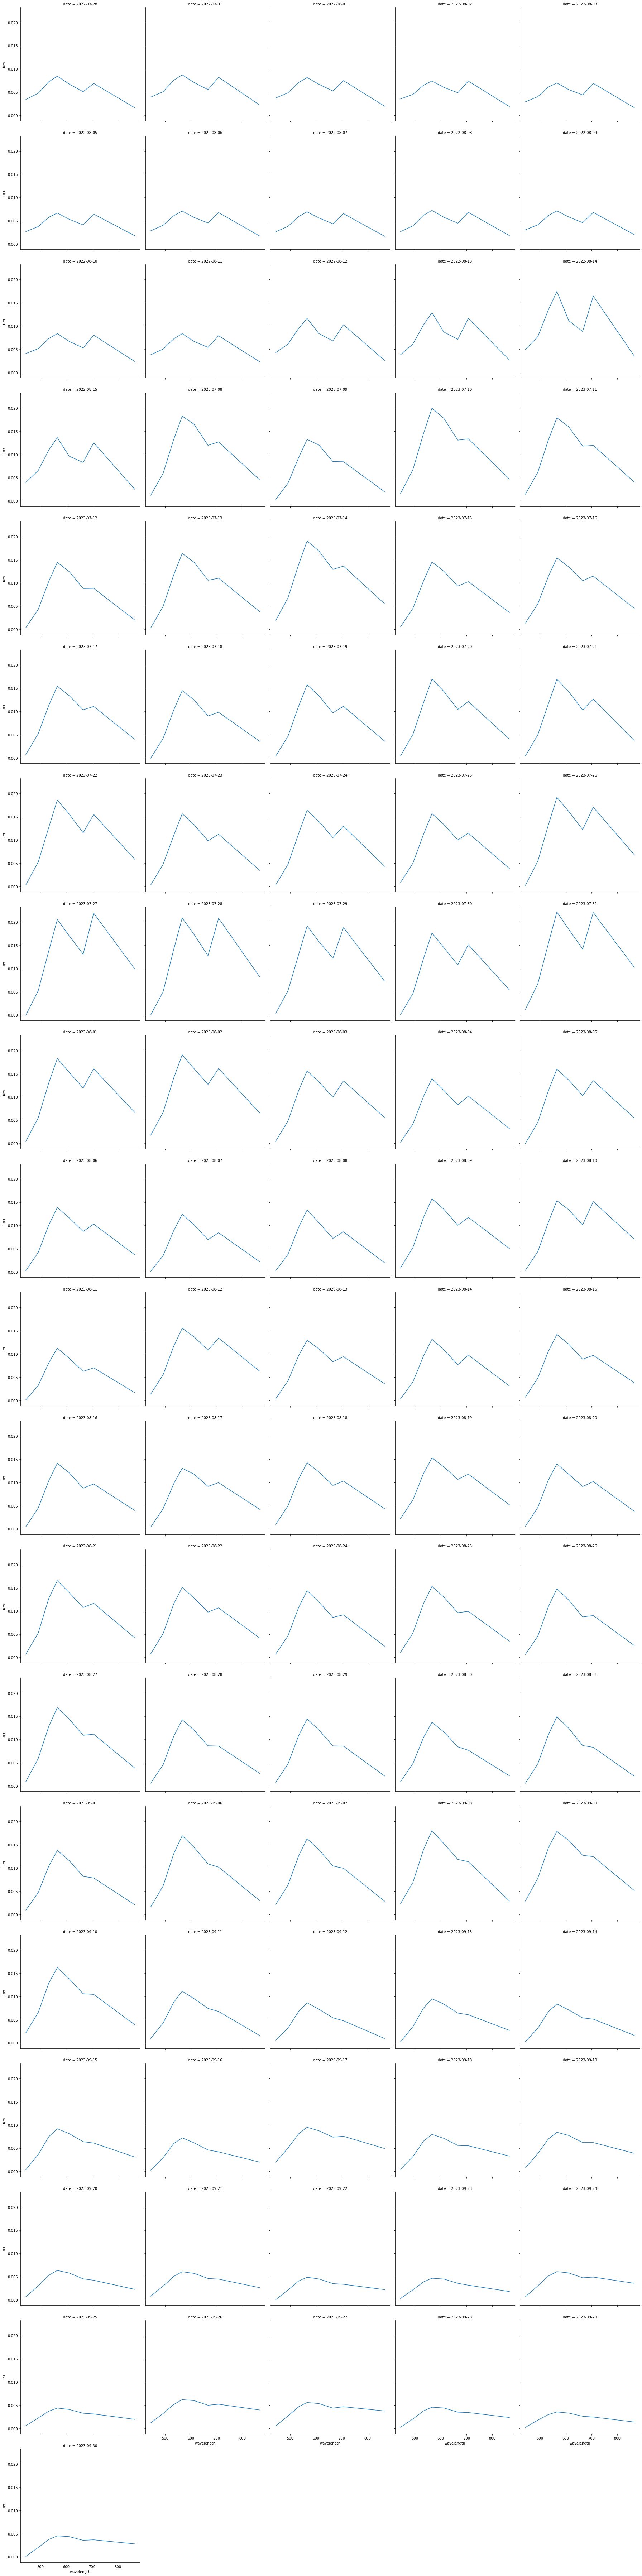

In [116]:
sns.relplot(data=SD_daily, x='wavelength', y='Rrs', col='date', kind='line', col_wrap=5)

In [118]:
dfCleanSD.to_csv('DALEC_SD_bands_2022_23_____.csv')

In [61]:
dfCleanS2.to_csv('DALEC_S2_bands_2022_23_____.csv')

In [60]:
dfCleanSD

Date       Rrs  wavelength        date  month  year
0     2022-07-28 10:00:00  0.003075       444.0  2022-07-28      7  2022
1     2022-07-28 10:00:00  0.004414       492.0  2022-07-28      7  2022
2     2022-07-28 10:00:00  0.006922       533.0  2022-07-28      7  2022
3     2022-07-28 10:00:00  0.008089       566.0  2022-07-28      7  2022
4     2022-07-28 10:00:00  0.006371       612.0  2022-07-28      7  2022
...                   ...       ...         ...         ...    ...   ...
37907 2023-09-30 12:50:00  0.004569       566.0  2023-09-30      9  2023
37908 2023-09-30 12:50:00  0.004379       612.0  2023-09-30      9  2023
37909 2023-09-30 12:50:00  0.003612       666.0  2023-09-30      9  2023
37910 2023-09-30 12:50:00  0.003717       707.0  2023-09-30      9  2023
37911 2023-09-30 12:50:00  0.002787       866.0  2023-09-30      9  2023

[37912 rows x 6 columns]